# Proyek Klasifikasi Gambar: [Input Nama Dataset]
- **Nama:** Ahmad Radesta
- **Email:** ahmadradesta95@gmail.com
- **ID Dicoding:** ahmad007

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.2 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [2]:
# Import standard libraries
import os
import random
import shutil
import pathlib
import pandas as pd
import numpy as np

# Import PIL for image processing
from PIL import Image

# Import matplotlib for plotting
import matplotlib.pyplot as plt

# Import TensorFlow and Keras libraries
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import EfficientNetV2B0, MobileNetV2

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Preparation

### Data Loading

In [4]:
!unzip "/content/drive/MyDrive/dataset (1)/archive.zip"

Streaming output truncated to the last 5000 lines.
  inflating: fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_277.jpg  
  inflating: fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_281.jpg  
  inflating: fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_285.jpg  
  inflating: fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_289.jpg  
  inflating: fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_29.jpg  
  inflating: fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_33.jpg  
  inflating: fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_37.jpg  
  inflating: fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_41.jpg  
  inflating: fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_45.jpg  
  inflating: fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_49.j

In [8]:
import os
import glob
import shutil
from PIL import Image
from sklearn.model_selection import train_test_split

def collect_images_and_labels(base_path):
    # List untuk menyimpan path gambar dan label
    image_paths = []
    labels = []
    class_names = set()

    for root, dirs, files in os.walk(base_path):
        # Mengabaikan folder root yang tidak memiliki gambar
        if root == base_path:
            continue
        class_name = os.path.basename(root)
        class_names.add(class_name)

        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                file_path = os.path.join(root, file)
                try:
                    with Image.open(file_path) as img:
                        image_paths.append(file_path)
                        labels.append(class_name)
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")
            else:
                print(f"Skipped non-image file: {file}")

    return image_paths, labels, sorted(list(class_names))

# Path ke folder utama
base_path = "/content/fruits-360_original-size/fruits-360-original-size"
output_dir = "/content/fruits_split"

# Verifikasi direktori
if not os.path.exists(base_path):
    raise FileNotFoundError(f"Direktori {base_path} tidak ditemukan. Pastikan dataset telah diunduh dan diekstrak.")

# Kumpulkan gambar dan label
image_paths, labels, class_names = collect_images_and_labels(base_path)

# Cetak statistik
print(f"Jumlah kelas: {len(class_names)}")
print(f"Total gambar: {len(image_paths)}")

Skipped non-image file: readme.txt
Jumlah kelas: 82
Total gambar: 52370


### Data Preprocessing

#### Split Dataset

In [9]:
# Lakukan stratified split
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=(val_ratio + test_ratio), stratify=labels, random_state=42
)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=test_ratio/(val_ratio + test_ratio), stratify=temp_labels, random_state=42
)

# Cetak statistik pembagian
print(f"Train: {len(train_paths)} gambar")
print(f"Validation: {len(val_paths)} gambar")
print(f"Test: {len(test_paths)} gambar")

# Buat direktori baru untuk dataset yang terbagi
for split in ['train', 'validation', 'test']:
    for class_name in class_names:
        os.makedirs(os.path.join(output_dir, split, class_name), exist_ok=True)

# Salin gambar ke direktori baru
def copy_images(paths, labels, split):
    for img_path, label in zip(paths, labels):
        dest_path = os.path.join(output_dir, split, label, os.path.basename(img_path))
        shutil.copy(img_path, dest_path)

copy_images(train_paths, train_labels, 'train')
copy_images(val_paths, val_labels, 'validation')
copy_images(test_paths, test_labels, 'test')

print("Pembagian dataset selesai!")

Train: 36659 gambar
Validation: 7855 gambar
Test: 7856 gambar
Pembagian dataset selesai!


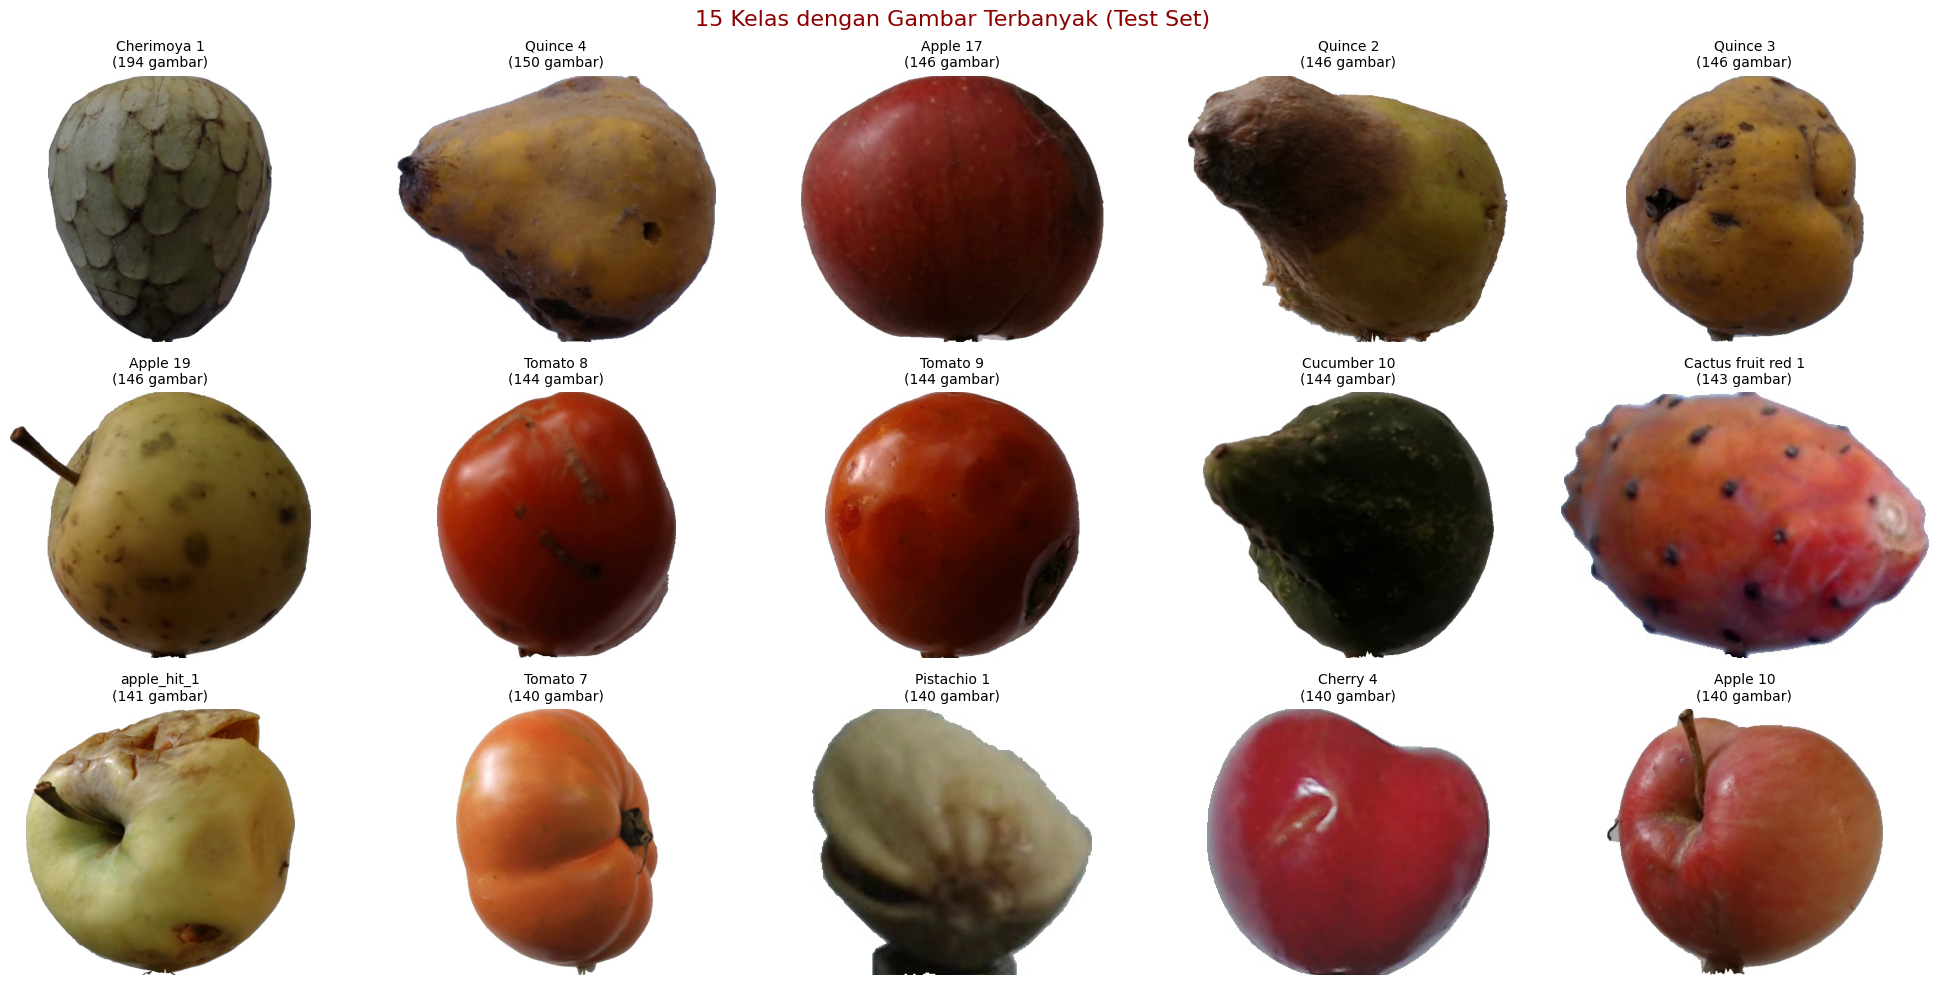

In [11]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import Counter

# Path ke test set
test_paths = "/content/fruits_split/test"

# Verifikasi direktori test
if not os.path.exists(test_paths):
    raise FileNotFoundError(f"Direktori {test_paths} tidak ditemukan. Pastikan pembagian dataset telah dilakukan.")

# Hitung jumlah gambar per kelas
class_image_counts = {}
for class_name in os.listdir(test_paths):
    class_path = os.path.join(test_paths, class_name)
    if os.path.isdir(class_path):
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        class_image_counts[class_name] = len(image_files)

# Ambil 15 kelas dengan jumlah gambar terbanyak
top_classes = sorted(class_image_counts.items(), key=lambda x: x[1], reverse=True)[:15]

# Tampilkan 1 gambar dari tiap kelas
plt.figure(figsize=(20, 10))
for i, (class_name, count) in enumerate(top_classes):
    class_path = os.path.join(test_paths, class_name)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if image_files:
        img_path = os.path.join(class_path, image_files[0])
        img = mpimg.imread(img_path)

        plt.subplot(3, 5, i+1)
        plt.imshow(img)
        plt.title(f"{class_name}\n({count} gambar)", fontsize=10)
        plt.axis('off')

plt.suptitle("15 Kelas dengan Gambar Terbanyak (Test Set)", fontsize=16, color='darkred')
plt.tight_layout()
plt.show()

In [17]:
img_size = (100, 100)
batch_size = 32

In [18]:
selected_classes = ["Apple 10", "Apple 11", "Apple 12", "Apple 13", "Apple 14", "Apple 17", "Apple 18", "Apple 19", "Apple 5",
    "Apple 7", "Apple 8", "Apple 9", "Apple Core 1", "Apple Red Yellow 2", "Apple worm 1", "Banana 3",
    "Beans 1", "Blackberrie 1", "Blackberrie 2", "Blackberrie half rippen 1", "Blackberrie not rippen 1",
    "Cabbage red 1", "Cactus fruit green 1", "Cactus fruit red 1", "Caju seed 1", "Cherimoya 1", "Cherry 3",
    "Cherry 4", "Cherry 5", "Cherry Rainier 2", "Cherry Rainier 3", "Cherry Sour 1", "Cherry Wax Red 2",
    "Cherry Wax Red 3", "Cherry Wax not ripen 1", "Cherry Wax not ripen 2", "Cucumber 10", "Cucumber 9",
    "Gooseberry 1", "Pistachio 1", "Quince 2", "Quince 3", "Quince 4", "Tomato 1", "Tomato 10", "Tomato 5",
    "Tomato 7", "Tomato 8", "Tomato 9", "Tomato Cherry Maroon 1", "Tomato Cherry Orange 1",
    "Tomato Cherry Red 2", "Tomato Cherry Yellow 1", "Tomato Maroon 2", "apple_6", "apple_braeburn_1"]

In [25]:
# Lokasi folder baru
base_dir = '/content/fruitsneww'

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Asal dataset
output_dir = "/content/fruits_split"

# Buat struktur folder
for split in ['train', 'validation', 'test']:
    for cls in selected_classes:
        src_path = os.path.join(output_dir, split, cls)
        dst_path = os.path.join(base_dir, split, cls)
        os.makedirs(dst_path, exist_ok=True)

        # Salin file (maksimal 100 file per kelas agar cepat)
        for file_name in os.listdir(src_path)[:100]:
            if file_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                shutil.copy(os.path.join(src_path, file_name), dst_path)


In [26]:
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, zoom_range=0.2)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
val_gen = val_datagen.flow_from_directory(val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
test_gen = test_datagen.flow_from_directory(test_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)


Found 5600 images belonging to 56 classes.
Found 4928 images belonging to 56 classes.
Found 4917 images belonging to 56 classes.


## Modelling

In [27]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(train_gen.num_classes, activation='softmax')  # Output sesuai jumlah kelas
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
# Compile model
optimizer = tf.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [29]:
# Callbacks
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, min_delta=0.001, restore_best_weights=True, mode='max', baseline=0.96)

In [30]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    callbacks=[checkpoint, early_stopping],
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 171s 959ms/step - accuracy: 0.2024 - loss: 3.1120 - val_accuracy: 0.6895 - val_loss: 0.9470
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 158s 898ms/step - accuracy: 0.7656 - loss: 0.7248 - val_accuracy: 0.8888 - val_loss: 0.3345
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 162s 928ms/step - accuracy: 0.8650 - loss: 0.4301 - val_accuracy: 0.9162 - val_loss: 0.2785
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 196s 891ms/step - accuracy: 0.9142 - loss: 0.2598 - val_accuracy: 0.9460 - val_loss: 0.1667
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 160s 915ms/step - accuracy: 0.9194 - loss: 0.2410 - val_accuracy: 0.9655 - val_loss: 0.0969
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 161s 922ms/step - accuracy: 0.9491 - loss: 0.1479 - val_accuracy: 0.9578 - val_loss: 0.1179
Epoch 7/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 151s 861ms/step - accuracy: 0.9474 - loss: 0.1486 - val_accuracy: 0.9740 - val_loss: 0.0676
Epoch 8/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 156s 891ms/step - accuracy: 0.9573 -

## Evaluasi dan Visualisasi

In [34]:
loss, accuracy = model.evaluate(test_gen)
print(f"Akurasi pada Test Set: {accuracy * 100:.2f}%")
print(f"Loss pada Test Set: {loss:.4f}")

loss, accuracy = model.evaluate(train_gen)
print(f"Akurasi pada Train Set: {accuracy * 100:.2f}%")
print(f"Loss pada Train Set: {loss:.4f}")


154/154 ━━━━━━━━━━━━━━━━━━━━ 31s 198ms/step - accuracy: 0.9810 - loss: 0.0480
Akurasi pada Test Set: 97.60%
Loss pada Test Set: 0.0694
175/175 ━━━━━━━━━━━━━━━━━━━━ 48s 272ms/step - accuracy: 0.9706 - loss: 0.0827
Akurasi pada Train Set: 97.20%
Loss pada Train Set: 0.0810


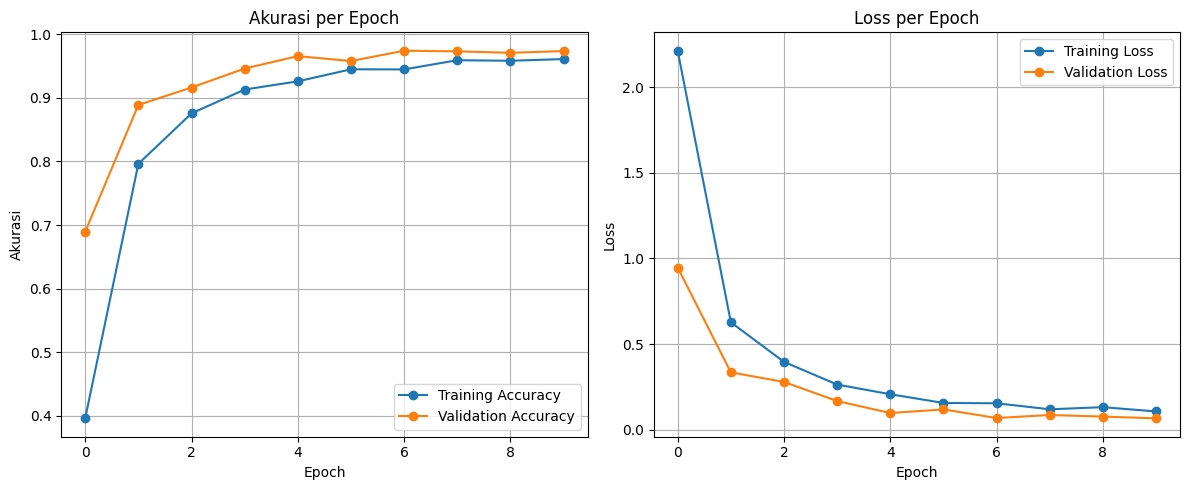

In [35]:
# Plot akurasi
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Akurasi per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Konversi Model

In [36]:
model.save("model.h5")

In [37]:
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model


2025-05-04 08:08:05.993702: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746346086.382404   38733 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746346086.485162   38733 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


In [38]:
save_path = os.path.join("saved_model")
tf.saved_model.save(model, save_path)

In [39]:
# Load the Keras model
model_TFLITE = tf.keras.models.load_model('model.h5')

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model_TFLITE)
tflite_model = converter.convert()

# Save the converted model to a file
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmp5345hv1y'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 56), dtype=tf.float32, name=None)
Captures:
  133093924403152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133093924398544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133093924403920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133093924401424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133093924402000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133093924398736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133093924402576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133093903697488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133093903696912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133093903698448: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [40]:
# Buat konten yang akan ditulis ke dalam file
content = """
"Apple 10", "Apple 11", "Apple 12", "Apple 13", "Apple 14", "Apple 17", "Apple 18", "Apple 19", "Apple 5",
"Apple 7", "Apple 8", "Apple 9", "Apple Core 1", "Apple Red Yellow 2", "Apple worm 1", "Banana 3",
"Beans 1", "Blackberrie 1", "Blackberrie 2", "Blackberrie half rippen 1", "Blackberrie not rippen 1",
"Cabbage red 1", "Cactus fruit green 1", "Cactus fruit red 1", "Caju seed 1", "Cherimoya 1", "Cherry 3",
"Cherry 4", "Cherry 5", "Cherry Rainier 2", "Cherry Rainier 3", "Cherry Sour 1", "Cherry Wax Red 2",
"Cherry Wax Red 3", "Cherry Wax not ripen 1", "Cherry Wax not ripen 2", "Cucumber 10", "Cucumber 9",
"Gooseberry 1", "Pistachio 1", "Quince 2", "Quince 3", "Quince 4", "Tomato 1", "Tomato 10", "Tomato 5",
"Tomato 7", "Tomato 8", "Tomato 9", "Tomato Cherry Maroon 1", "Tomato Cherry Orange 1",
"Tomato Cherry Red 2", "Tomato Cherry Yellow 1", "Tomato Maroon 2", "apple_6", "apple_braeburn_1"
"""

# Tentukan path dan nama file
file_path = "/content/KlasifikasiBuah.txt"

# Tulis konten ke dalam file
with open(file_path, "w") as file:
    file.write(content.strip())


In [42]:
# Specify the folder to zip
folder_modles = '/content/saved_model'
folder_tfjs_model = '/content/tfjs_model'

# Specify the output zip file name (without .zip extension)
output_modles= '/content/saved_model'
output_tfjs_model = '/content/tfjs_model'

# Zip the folder
shutil.make_archive(output_modles, 'zip', folder_modles)
shutil.make_archive(output_tfjs_model, 'zip', folder_tfjs_model)

'/content/tfjs_model.zip'

In [43]:
!pip freeze > requirements.txt

## Inference (Optional)

In [48]:
import tensorflow as tf
import numpy as np
import os

# Load model dari path .keras, .h5, atau SavedModel
model = tf.keras.models.load_model('/content/model.h5')  # Ganti path sesuai model kamu

# Daftar nama kelas sebagai list
class_names = [
    "Apple 10", "Apple 11", "Apple 12", "Apple 13", "Apple 14", "Apple 17", "Apple 18", "Apple 19", "Apple 5",
    "Apple 7", "Apple 8", "Apple 9", "Apple Core 1", "Apple Red Yellow 2", "Apple worm 1", "Banana 3",
    "Beans 1", "Blackberrie 1", "Blackberrie 2", "Blackberrie half rippen 1", "Blackberrie not rippen 1",
    "Cabbage red 1", "Cactus fruit green 1", "Cactus fruit red 1", "Caju seed 1", "Cherimoya 1", "Cherry 3",
    "Cherry 4", "Cherry 5", "Cherry Rainier 2", "Cherry Rainier 3", "Cherry Sour 1", "Cherry Wax Red 2",
    "Cherry Wax Red 3", "Cherry Wax not ripen 1", "Cherry Wax not ripen 2", "Cucumber 10", "Cucumber 9",
    "Gooseberry 1", "Pistachio 1", "Quince 2", "Quince 3", "Quince 4", "Tomato 1", "Tomato 10", "Tomato 5",
    "Tomato 7", "Tomato 8", "Tomato 9", "Tomato Cherry Maroon 1", "Tomato Cherry Orange 1",
    "Tomato Cherry Red 2", "Tomato Cherry Yellow 1", "Tomato Maroon 2", "apple_6", "apple_braeburn_1"
]

# Mapping indeks ke nama kelas
map_labels = {i: name for i, name in enumerate(class_names)}

# Contoh cetak 5 pertama
for k in list(map_labels)[:5]:
    print(f"{k}: {map_labels[k]}")


# Fungsi untuk preprocessing gambar
def images_preprocessing(filenames):
    image_tensors = []
    for filename in filenames:
        # Baca gambar dari file
        image = tf.io.decode_image(open(filename, 'rb').read(), channels=3)

        # Resize gambar ke ukuran yang sesuai dengan input model
        image = tf.image.resize(image, [100, 100])  # Ganti ukuran sesuai input model

        # Normalisasi
        image = image / 255.0

        # Tambahkan dimensi batch
        image_tensor = tf.expand_dims(image, 0)

        image_tensors.append(image_tensor)

    return tf.concat(image_tensors, axis=0)


# Daftar gambar yang ingin diuji
filenames = [
    '/content/fruitsneww/test/Apple 10/r0_104.jpg',
    '/content/fruitsneww/test/Banana 3/r0_10.jpg',
    '/content/fruitsneww/test/Cherry Wax Red 3/r0_10.jpg'
]

# Preprocess
batch_images = images_preprocessing(filenames)

# Prediksi
predictions = model.predict(batch_images)

# Tampilkan hasil prediksi
print("Hasil Prediksi:")
for i, prediction in enumerate(predictions):
    predicted_class = tf.argmax(prediction).numpy()
    confidence = tf.reduce_max(prediction).numpy()
    print(f"{os.path.basename(filenames[i])}: {map_labels[predicted_class]} (confidence: {confidence:.2f})")


0: Apple 10
1: Apple 11
2: Apple 12
3: Apple 13
4: Apple 14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Hasil Prediksi:
r0_104.jpg: Apple 10 (confidence: 1.00)
r0_10.jpg: Banana 3 (confidence: 1.00)
r0_10.jpg: Cherry Wax Red 3 (confidence: 1.00)
